<a href="https://colab.research.google.com/github/albey-code/hippoabstraction/blob/main/SR_model_based_DSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Successor Representation Preparation

The goal of this notebook is to prepare the analytical solution to the successor representation (SR) paradigm. In addition, I am equally curious to try an "on-policy", instead of an "off-policy", version of it. This way, I will take the learned transition probabilities from the 12-node graph from Garvert et al. (2017) into account. This can be done by a) integrating the transition probabilities into the transition matrix T, or b) by using the SR framework with the delta rule update.

1. Adjacency matrix → Transition matrix

2. Transition matrix → Successor representation (SR) matrix

3. SR matrix → Model-based dissimilarity matrix (DSM)

# Step 1: Build the Adjacency and Transition Matrices

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# Step 1: Define the adjacency matrix (12x12 binary matrix where 1 encodes a connection and 0 no connection)
# This is from Valerio's Matlab matrix!
A = np.array([
    [0,1,1,1,0,0,0,0,0,0,0,0],
    [1,0,0,1,1,0,0,0,0,0,0,0],
    [1,0,0,1,0,1,1,0,0,0,0,0],
    [1,1,1,0,1,0,1,0,0,0,0,0],
    [0,1,0,1,0,0,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,1,0,1,0,1,0,1,1,0],
    [0,0,0,0,1,0,1,0,1,0,1,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [0,0,0,0,0,1,1,0,0,0,1,0],
    [0,0,0,0,0,0,1,1,0,1,0,1],
    [0,0,0,0,0,0,0,1,1,0,1,0]
])

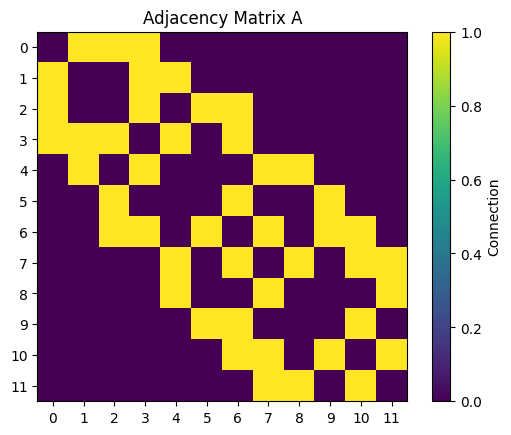

In [7]:
# Visualize adjacency matrix
plt.imshow(A, cmap='viridis')
plt.colorbar(label='Connection')
plt.title("Adjacency Matrix A")

# Force every tick to be shown
num_nodes = A.shape[0]
plt.xticks(ticks=np.arange(num_nodes))  # 0 to 11
plt.yticks(ticks=np.arange(num_nodes))  # 0 to 11

plt.show()

In [8]:
# Step 2: Compute transition matrix T
T = A / A.sum(axis=1, keepdims=True)

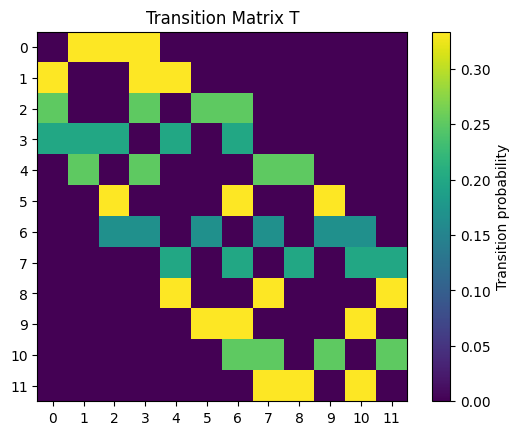

In [9]:
# Visualize transition matrix
plt.imshow(T, cmap='viridis')
plt.colorbar(label='Transition probability')
plt.title("Transition Matrix T")

# Force every tick to be shown to avoid confusion with Matlab convention from 1 to 12 instead of 0 to 11
num_nodes = T.shape[0]
plt.xticks(ticks=np.arange(num_nodes))  # 0 to 11
plt.yticks(ticks=np.arange(num_nodes))  # 0 to 11

plt.show()

# Step 2: Compute the Successor Representation Matrix

The SR matrix (M) gives the expected future occupancy for a random walk starting at each node.

> M = (I−γT)−1





In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Step 3: Build identity matrix I manually

I = np.array ([
    [1,0,0,0,0,0,0,0,0,0,0,0],
    [0,1,0,0,0,0,0,0,0,0,0,0],
    [0,0,1,0,0,0,0,0,0,0,0,0],
    [0,0,0,1,0,0,0,0,0,0,0,0],
    [0,0,0,0,1,0,0,0,0,0,0,0],
    [0,0,0,0,0,1,0,0,0,0,0,0],
    [0,0,0,0,0,0,1,0,0,0,0,0],
    [0,0,0,0,0,0,0,1,0,0,0,0],
    [0,0,0,0,0,0,0,0,1,0,0,0],
    [0,0,0,0,0,0,0,0,0,1,0,0],
    [0,0,0,0,0,0,0,0,0,0,1,0],
    [0,0,0,0,0,0,0,0,0,0,0,1]
])

In [12]:
# Step 4: Compute 100 gamma values from 0.00 to 0.99

gamma_values = np.linspace(0.00, 0.99, 100)

In [13]:
# Step 5: Take transition matrix computed earlier

T = A / A.sum(axis=1, keepdims=True)

In [14]:
# Step 6: Loop to compute 100 SR matrices

SR_matrices = []  # list to store the 100 SR matrices

In [15]:
# Step 7: It all comes together

for gamma in gamma_values:
    # (I - gamma * T)
    difference = I - gamma * T
    # Compute the inverse of (I - gamma * T)
    M = np.linalg.inv(difference)
    SR_matrices.append(M)

print(f"Computed {len(SR_matrices)} SR matrices.")

Computed 100 SR matrices.


Optional: visualization of selected SR matrices to see how the predictive horizon expands as γ increases

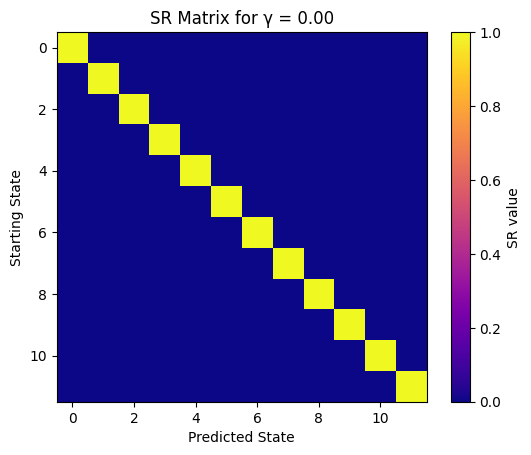

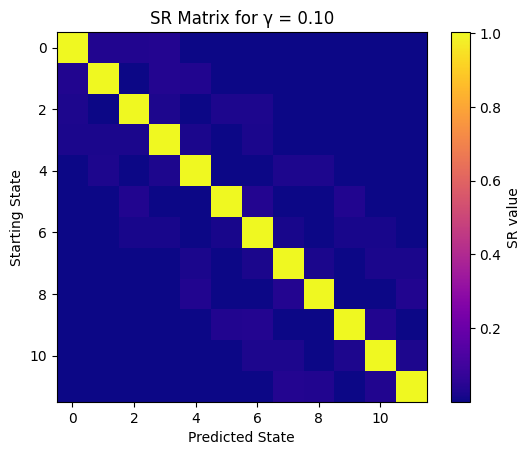

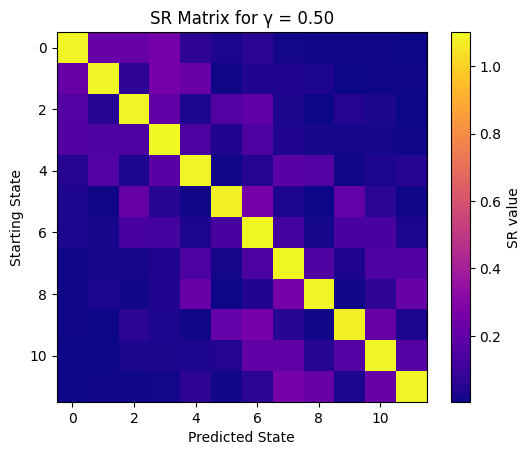

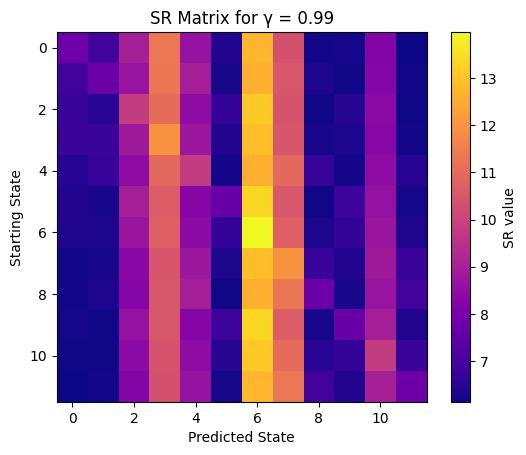

In [16]:
# Visualize SR matrices for selected gamma values
selected_indices = [0, 10, 50, 99]  # gamma = 0.00, 0.10, 0.50, 0.99

for idx in selected_indices:
    gamma = gamma_values[idx]
    M = SR_matrices[idx]

    plt.figure()
    plt.imshow(M, cmap='plasma')
    plt.colorbar(label='SR value')
    plt.title(f"SR Matrix for γ = {gamma:.2f}")
    plt.xlabel("Predicted State")
    plt.ylabel("Starting State")
    plt.show()


# Step 3: Compute Model-Based DSM

Since I obtained 100 different γ values for 100 different SR matrices, I can now compute 100 different dissimilarity matrices (DSMs), one for each M(γ).

A DSM compares the rows of an SR matrix:

* Each row is the “prediction profile” from a starting state
* The DSM entry [i, j] is the dissimilarity between row i and row j

Most commonly: dissimilarity = 1 - correlation (M[i, :], M[j, :])

In [17]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Function to compute 1 - Pearson correlation DSM from an SR matrix
def compute_dsm(sr_matrix):
    n = sr_matrix.shape[0]
    dsm = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            r, _ = pearsonr(sr_matrix[i], sr_matrix[j])
            dsm[i, j] = 1 - r  # 1 - similarity = dissimilarity
    return dsm

In [19]:
# Assuming SR_matrices already exists (my 100 SR matrices)

DSM_matrices = []  # list to store 100 DSMs

In [20]:
for M in SR_matrices:
    dsm = compute_dsm(M)
    DSM_matrices.append(dsm)

print(f"Computed {len(DSM_matrices)} DSMs.")

Computed 100 DSMs.


Optional: visualization of selected DSM matrices

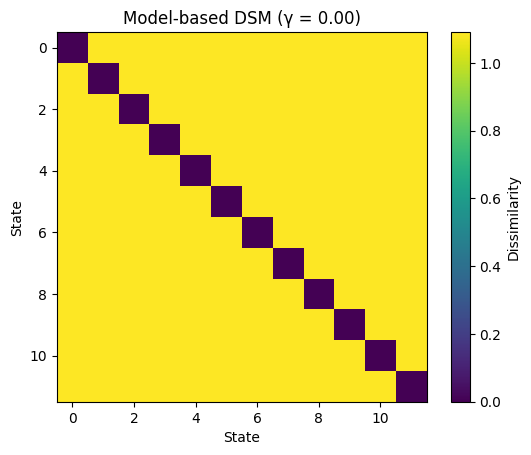

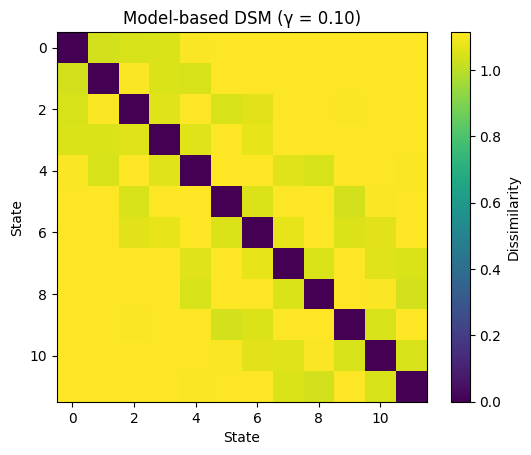

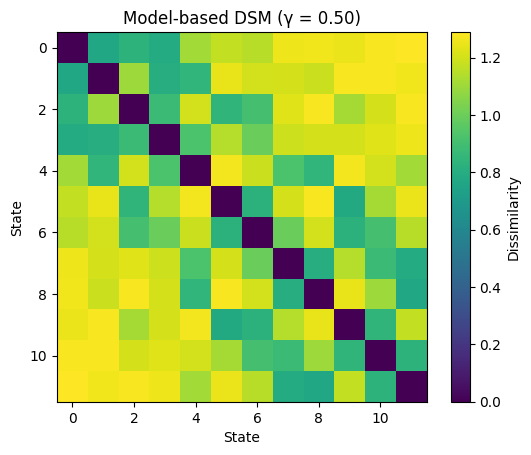

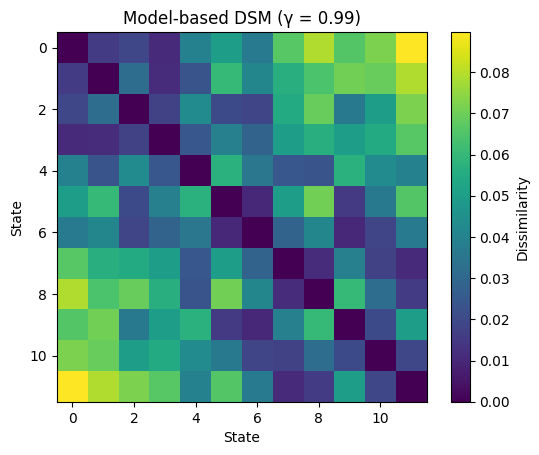

In [21]:
# Visualize DSMs for selected gamma values
selected_indices = [0, 10, 50, 99]

for idx in selected_indices:
    gamma = gamma_values[idx]
    dsm = DSM_matrices[idx]

    plt.figure()
    plt.imshow(dsm, cmap='viridis')
    plt.colorbar(label='Dissimilarity')
    plt.title(f"Model-based DSM (γ = {gamma:.2f})")
    plt.xlabel("State")
    plt.ylabel("State")
    plt.show()